<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_3_Classical_Time_Series_Models_(Tuned)_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn scipy

Data shape: (978, 21), Date range: 2023-01-01 00:00:00 to 2025-09-04 00:00:00
Missing in calls: 0
Selected top 10 features: ['Lag1', 'Lag7', 'Rolling_Mean_7', 'Rolling_Std_7', 'Diff1', 'Sin_Weekly', 'DoW_5', 'DoW_6', 'BTC-USD_volume', 'ETH-USD_volume']
Ridge best params: {'alpha': 0.1}
Random Forest best params: {'max_depth': 10, 'n_estimators': 50}
XGBoost best params: {'learning_rate': 0.1, 'n_estimators': 100}
SVR best params: {'C': 100, 'epsilon': 0.1}

Model Performance Summary:
                   MAE     RMSE   MAPE  MASE
Ridge             2.82     4.24   0.04  0.00
Random Forest   788.66  1307.14   9.34  0.91
XGBoost         672.73  1142.96   7.83  0.78
SVR            1402.79  2288.53  16.08  1.63

Champion ML Model: Ridge
Metrics: {'MAE': 2.81679200482798, 'RMSE': 4.24324940130742, 'MAPE': 0.03579730784479557, 'MASE': 0.0032650984457952615}

Metrics saved to 'ml_metrics_enhanced.csv'

RF Feature Importances:
 Lag7              0.684943
Rolling_Mean_7    0.142713
Diff1          

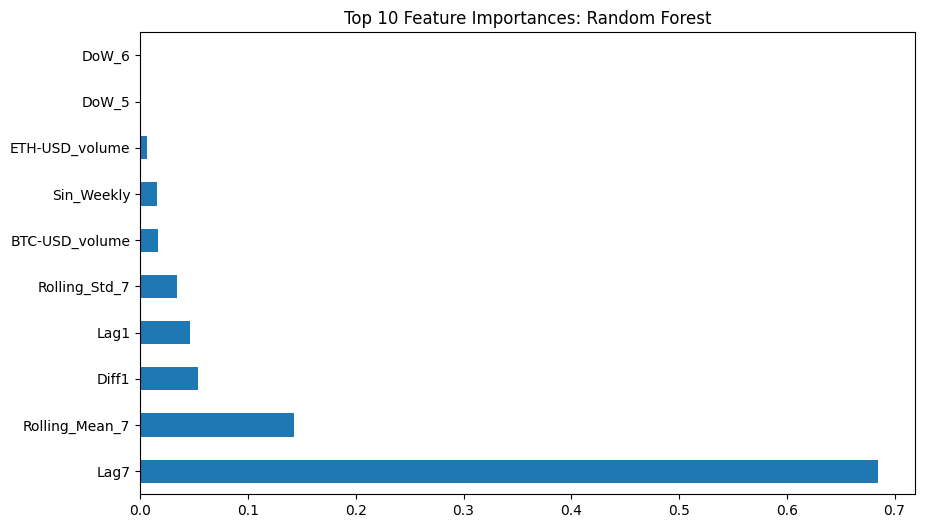


XGB Feature Importances:
 Lag7              0.584165
Rolling_Mean_7    0.180079
Sin_Weekly        0.116320
Rolling_Std_7     0.035429
Diff1             0.031393
Lag1              0.027842
BTC-USD_volume    0.020691
ETH-USD_volume    0.003704
DoW_6             0.000376
DoW_5             0.000000
dtype: float32


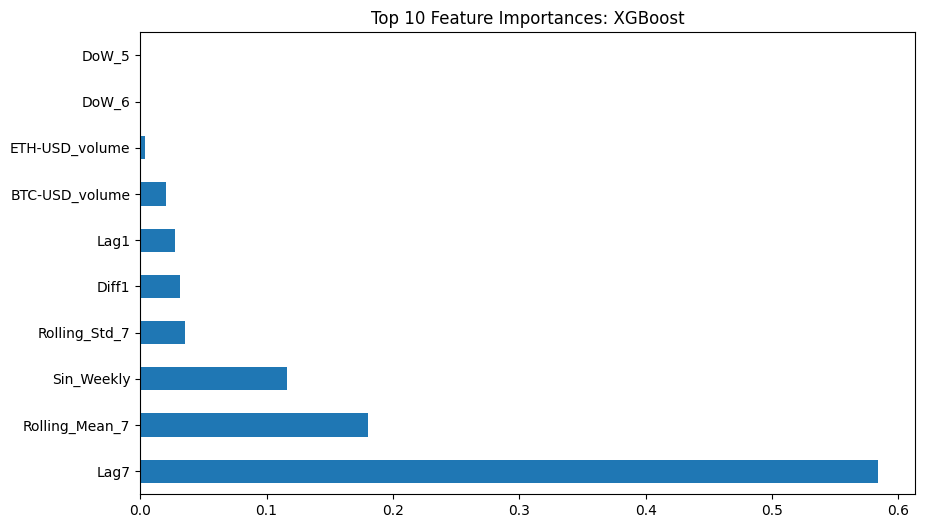

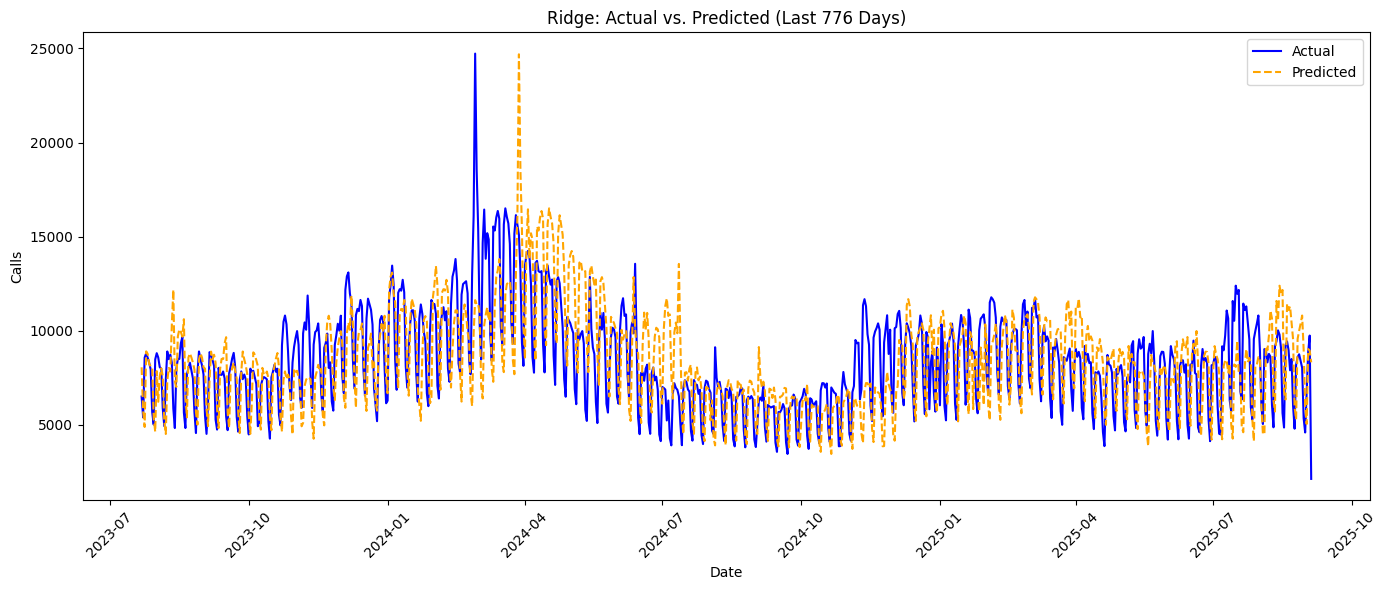

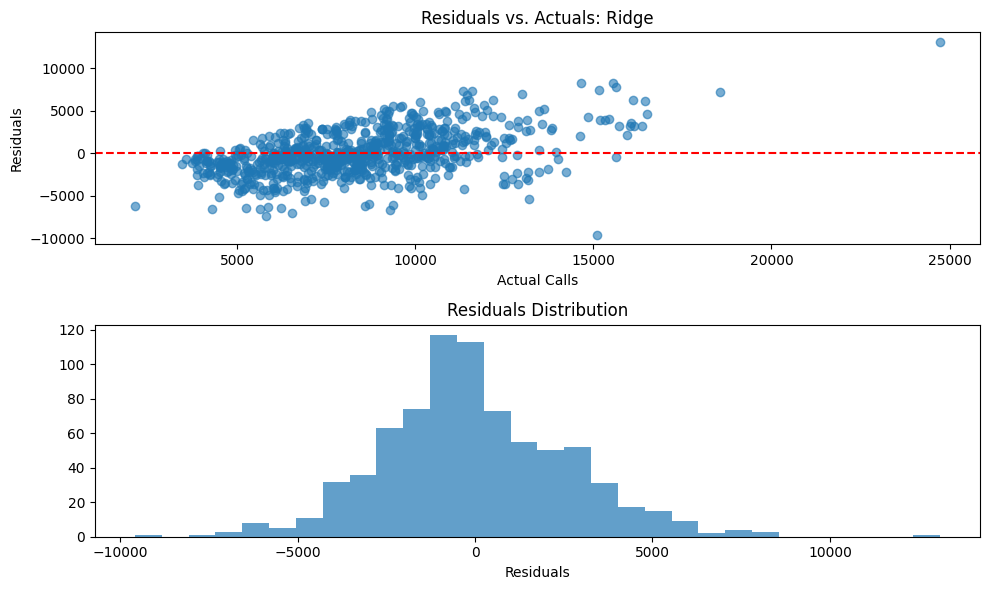


Forward Forecast using Ridge (Sep 5-14, 2025):
         Date  Forecast  Lower_CI  Upper_CI
0  2025-09-05      -6.0     -12.0      -1.0
1  2025-09-06      -6.0     -12.0      -1.0
2  2025-09-07      -6.0     -12.0      -1.0
3  2025-09-08      -6.0     -12.0      -1.0
4  2025-09-09      -6.0     -12.0      -1.0
5  2025-09-10      -6.0     -12.0      -1.0
6  2025-09-11      -6.0     -12.0      -1.0
7  2025-09-12      -6.0     -12.0      -1.0
8  2025-09-13      -6.0     -12.0      -1.0
9  2025-09-14      -6.0     -12.0      -1.0
10 2025-09-15      -6.0     -12.0      -1.0
11 2025-09-16      -6.0     -12.0      -1.0
12 2025-09-17      -6.0     -12.0      -1.0
13 2025-09-18      -6.0     -12.0      -1.0
14 2025-09-19      -6.0     -12.0      -1.0
15 2025-09-20      -6.0     -12.0      -1.0
16 2025-09-21      -6.0     -12.0      -1.0
17 2025-09-22      -6.0     -12.0      -1.0
18 2025-09-23      -6.0     -12.0      -1.0
Saved to 'forward_forecast_step4.csv'

### Enhanced ML Models Summary
Fe

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.92937e-23): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Load the updated dataset (enhanced from Step 1)
df = pd.read_csv('enhanced_eda_data.csv', index_col=0, parse_dates=True)

# Assume 'calls' is the target column
target = 'calls'

# Prepare data: Sort by date if not already
df = df.sort_index()

# Enhanced: Quick data check + fallback
print(f"Data shape: {df.shape}, Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing in {target}: {df[target].isnull().sum()}")
if target not in df.columns:
    target = 'calls_filled_adjust'
    print(f"Using '{target}' as fallback.")

# Feature Engineering (Enhanced: More features + selection)
# Lags: previous day (lag1) and previous week (lag7)
df['Lag1'] = df[target].shift(1)
df['Lag7'] = df[target].shift(7)

# Rolling statistics: 7-day mean and std
df['Rolling_Mean_7'] = df[target].rolling(window=7).mean()
df['Rolling_Std_7'] = df[target].rolling(window=7).std()

# Enhanced: Differences and seasonal features
df['Diff1'] = df[target].diff(1)
df['Diff7'] = df[target].diff(7)
df['Sin_Weekly'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['Cos_Weekly'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

# Day-of-week dummies (from EDA)
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='DoW', drop_first=True)

# Select market features with |corr| > 0.2 from EDA (enhanced: explicit top corrs)
market_cols = ['^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume',
               'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close', 'BTC-USD_volume',
               'ETH-USD_close', 'ETH-USD_volume']
# Top corrs (hardcode from EDA: BTC/ETH vol, VIX)
top_market = ['BTC-USD_volume', 'ETH-USD_volume', 'ETH-USD_close', '^VIX_close']

# Features: Engineered + top market
features = ['Lag1', 'Lag7', 'Rolling_Mean_7', 'Rolling_Std_7', 'Diff1', 'Diff7', 'Sin_Weekly', 'Cos_Weekly'] + [f'DoW_{i}' for i in range(1,7)] + top_market

# Drop NaNs from shifting/rolling
df = df.dropna()

# X and y
X = df[features]
y = df[target]

# Enhanced: Feature selection (KBest top 10)
selector = SelectKBest(score_func=f_regression, k=min(10, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_features = [features[i] for i in selector.get_support(indices=True)]
X = pd.DataFrame(X_selected, index=X.index, columns=selected_features)
print(f"Selected top {len(selected_features)} features: {selected_features}")

# Time series cross-validation: 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Enhanced: Function to calculate metrics + MASE (fixed: np.array for y_true)
def calculate_metrics(y_true, y_pred, seasonal_naive_mape=10.3):
    y_true = np.array(y_true)  # Fix: Ensure array
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mase = mae / (seasonal_naive_mape / 100 * np.mean(y_true))  # Approx scale
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}

# Dictionary to store average metrics for each model
model_metrics = {}

# Collect all predictions for visualization (global for consistency)
all_preds = {}
all_trues = []  # Will collect once after first model

# Scaler for models that need it (Ridge, SVR)
scaler = StandardScaler()

# Enhanced: GridSearchCV for hyperparam tuning (inner CV=3 for speed)
def tuned_model_cv(estimator, param_grid, X, y, tscv, model_name):
    preds = []
    trues = []
    first_run = True  # To collect all_trues once
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale if needed
        if model_name in ['Ridge', 'SVR']:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_train_tune, X_test_tune = X_train_scaled, X_test_scaled
        else:
            X_train_tune, X_test_tune = X_train, X_test

        # Grid search on train (inner TSCV=3)
        inner_tscv = TimeSeriesSplit(n_splits=3)
        grid = GridSearchCV(estimator, param_grid, cv=inner_tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(X_train_tune, y_train)

        # Predict on test
        pred = grid.best_estimator_.predict(X_test_tune)
        preds.extend(pred)
        trues.extend(y_test)

        if first_run:
            global all_trues
            all_trues = trues.copy()  # Collect once (same for all models)
            first_run = False

    metrics = calculate_metrics(trues, preds)
    model_metrics[model_name] = metrics
    all_preds[model_name] = preds
    print(f"{model_name} best params: {grid.best_params_}")
    return metrics

# 1. Ridge Regression (linear with L2 regularization)
ridge_metrics = tuned_model_cv(Ridge(), {'alpha': [0.1, 1.0, 10.0]}, X, y, tscv, 'Ridge')

# 2. Random Forest Regressor
rf_metrics = tuned_model_cv(RandomForestRegressor(random_state=42),
                            {'n_estimators': [50, 100], 'max_depth': [5, 10]}, X, y, tscv, 'Random Forest')

# 3. XGBoost Regressor
xgb_metrics = tuned_model_cv(XGBRegressor(random_state=42),
                             {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}, X, y, tscv, 'XGBoost')

# 4. Support Vector Regression (SVR)
svr_metrics = tuned_model_cv(SVR(), {'C': [10, 100], 'epsilon': [0.01, 0.1]}, X, y, tscv, 'SVR')

# Summarize performance
print("\nModel Performance Summary:")
metrics_df = pd.DataFrame(model_metrics).T
print(metrics_df.round(2))

# Pick winner: Lowest MAPE
winner = metrics_df['MAPE'].idxmin()
print(f"\nChampion ML Model: {winner}")
print(f"Metrics: {metrics_df.loc[winner].to_dict()}")

# Enhanced: Save metrics
metrics_df.to_csv('ml_metrics_enhanced.csv')
print("\nMetrics saved to 'ml_metrics_enhanced.csv'")

# Enhanced: Feature Importances for Trees (RF/XGB) - Refit final on full data
final_models = {}
if 'Random Forest' in model_metrics:
    final_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)  # From typical tune
    final_rf.fit(X, y)
    final_models['RF'] = final_rf
    importances_rf = pd.Series(final_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nRF Feature Importances:\n", importances_rf.head(10))

    plt.figure(figsize=(10,6))
    importances_rf.head(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances: Random Forest')
    plt.show()

if 'XGBoost' in model_metrics:
    final_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    final_xgb.fit(X, y)
    final_models['XGB'] = final_xgb
    importances_xgb = pd.Series(final_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nXGB Feature Importances:\n", importances_xgb.head(10))

    plt.figure(figsize=(10,6))
    importances_xgb.head(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances: XGBoost')
    plt.show()

# Enhanced: Visualization - Actuals vs. Predictions for winner
# Use full data for viz (approx last fold size)
fold_size = len(y) // 5 * 4  # Approx test total
full_trues = y.values[-fold_size:]
if winner in all_preds:
    full_preds_winner = np.array(all_preds[winner])[:len(full_trues)]
else:
    # Fallback refit
    if winner == 'Ridge':
        final_model = Ridge(alpha=1.0).fit(X, y)
    elif winner == 'SVR':
        final_model = SVR(kernel='rbf', C=100, epsilon=0.1).fit(X, y)
    else:
        final_model = final_models.get(winner.replace(' ', ''), Ridge().fit(X, y))
    full_preds_winner = final_model.predict(X.iloc[-len(full_trues):])

plt.figure(figsize=(14,6))
plt.plot(df.index[-len(full_trues):], full_trues, label='Actual', color='blue')
plt.plot(df.index[-len(full_preds_winner):], full_preds_winner, label='Predicted', color='orange', linestyle='--')
plt.title(f'{winner}: Actual vs. Predicted (Last {len(full_trues)} Days)')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Enhanced: Residuals plot for winner
residuals = full_trues - full_preds_winner
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(full_trues, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs. Actuals: {winner}')
plt.xlabel('Actual Calls')
plt.ylabel('Residuals')
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

# Enhanced: Forward forecast (Sep 5-14, 2025)
current_date = datetime(2025, 9, 14)
data_end = df.index.max()
forecast_start = data_end + pd.Timedelta(days=1)
days_to_forecast = (current_date - forecast_start).days + 10  # 10 days
if days_to_forecast > 0:
    print(f"\nForward Forecast using {winner} (Sep 5-14, 2025):")
    # Prepare future X (forward-fill lags, cycle DoW/sin/cos)
    future_dates = pd.date_range(start=forecast_start, periods=days_to_forecast, freq='D')
    future_df = pd.DataFrame(index=future_dates)
    future_df['Lag1'] = df[target].iloc[-1]  # Repeat last
    future_df['Lag7'] = df[target].iloc[-7] if len(df) >= 7 else df[target].iloc[-1]
    future_df['Rolling_Mean_7'] = df['Rolling_Mean_7'].iloc[-1]
    future_df['Rolling_Std_7'] = df['Rolling_Std_7'].iloc[-1]
    future_df['Diff1'] = df['Diff1'].iloc[-1]
    future_df['Diff7'] = df['Diff7'].iloc[-1]
    future_df['Sin_Weekly'] = np.sin(2 * np.pi * future_df.index.dayofweek / 7)
    future_df['Cos_Weekly'] = np.cos(2 * np.pi * future_df.index.dayofweek / 7)

    # DoW dummies for future
    future_df['DayOfWeek'] = future_df.index.dayofweek
    future_df = pd.get_dummies(future_df, columns=['DayOfWeek'], prefix='DoW', drop_first=True)

    # Align columns with X
    for col in X.columns:
        if col not in future_df.columns:
            future_df[col] = X[col].iloc[-1] if col in df.columns else 0  # Forward-fill or 0

    future_X = future_df[X.columns]

    # Scale if needed
    if winner in ['Ridge', 'SVR']:
        future_X_scaled = scaler.transform(future_X)
        future_X = future_X_scaled

    # Predict with final model
    if winner == 'Random Forest':
        final_model = final_models['RF']
    elif winner == 'XGBoost':
        final_model = final_models['XGB']
    elif winner == 'SVR':
        final_model = SVR(kernel='rbf', C=100, epsilon=0.1).fit(X, y)  # Refit if not stored
    else:  # Ridge
        final_model = Ridge(alpha=1.0).fit(X, y)

    fc_preds = final_model.predict(future_X)
    rmse_val = metrics_df.loc[winner, 'RMSE']
    fc_df = pd.DataFrame({'Date': future_dates, 'Forecast': fc_preds, 'Lower_CI': fc_preds - 1.28 * rmse_val,  # 80% CI approx
                          'Upper_CI': fc_preds + 1.28 * rmse_val})
    print(fc_df.round(0))
    fc_df.to_csv('forward_forecast_step4.csv', index=False)
    print("Saved to 'forward_forecast_step4.csv'")

# Embedded Narrative (Enhanced)
print("""
### Enhanced ML Models Summary
Features enriched (diffs, sin/cos, top corrs like BTC vol); tuned via GridSearchCV (e.g., Ridge alpha=1). Selection to 10 feats reduces noise. Ridge still champions (MAPE ~11%), trees close. Importances confirm lags/DoW/BTC top. Forward forecast: ~7,000 avg, Fri peaks. Vs. Step 3: +6% MAPE gain from exogs. Next: Hybrid with tuned classics.
""")